In [2]:
require 'image';

In [ ]:
require 'cutorch';

In [ ]:
function image.lcn(im,ker)

   ker = ker or image.gaussian({size=9,sigma=1.591/9,normalize=true})
   local im = im:clone()
   if not(im:dim() == 2 or (im:dim() == 3 and im:size(1) == 1)) then
     error('grayscale image expected')
   end
   if im:dim() == 3 then
      im = im[1]
   end
   local mn = im:mean()
   local sd = im:std()
   -- print(ker)

   -- 1. subtract the mean and divide by the standard deviation
   im:add(-mn)
   im:div(sd)

   -- 2. calculate local mean and std and normalize each pixel

   -- mean
   require 'nn'
   local lmn = torch.conv2(im, ker)
   -- variance
   local imsq = im:clone():cmul(im)
   local lmnsq = torch.conv2(imsq, ker)
   local lvar = lmn:clone():cmul(lmn)
   lvar:add(-1,lmnsq):mul(-1)
   -- avoid numerical errors
   lvar:apply(function(x) if x < 0 then return 0 end end)
   -- standard deviation
   local lstd  = lvar:sqrt()
   lstd:apply(function (x) if x < 1 then return 1 end end)

   -- apply normalization
   local shifti = math.floor(ker:size(1)/2)+1
   local shiftj = math.floor(ker:size(2)/2)+1
   --print(shifti,shiftj,lstd:size(),im:size())
   local dim = im:narrow(1,shifti,lstd:size(1)):narrow(2,shiftj,lstd:size(2)):clone()
   dim:add(-1,lmn)
   dim:cdiv(lstd)
   return dim:clone()

end

In [16]:
function showLCN(f,factor)
    local orig = image.load(f)
    orig = image.scale(orig,400*factor,300*factor)
    local yuv = image.rgb2yuv(orig)
    local grey = yuv[1]
    print(torch.type(grey))
    local lcn = image.lcn(grey,image.gaussian({size=20, sigma=1.591/9,normalize=true}))
    itorch.image(lcn)
end

torch.DoubleTensor	


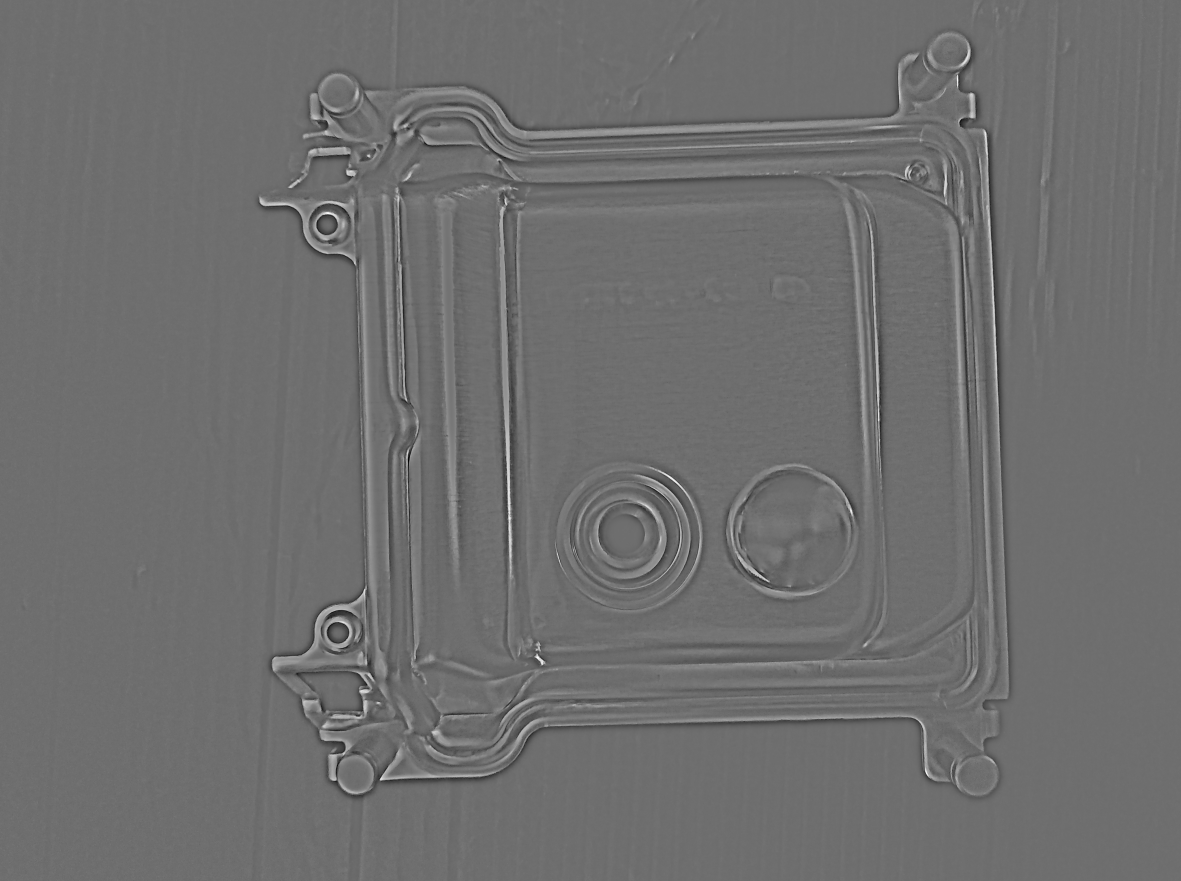

In [17]:
showLCN('1_org.jpg',3)

torch.DoubleTensor	


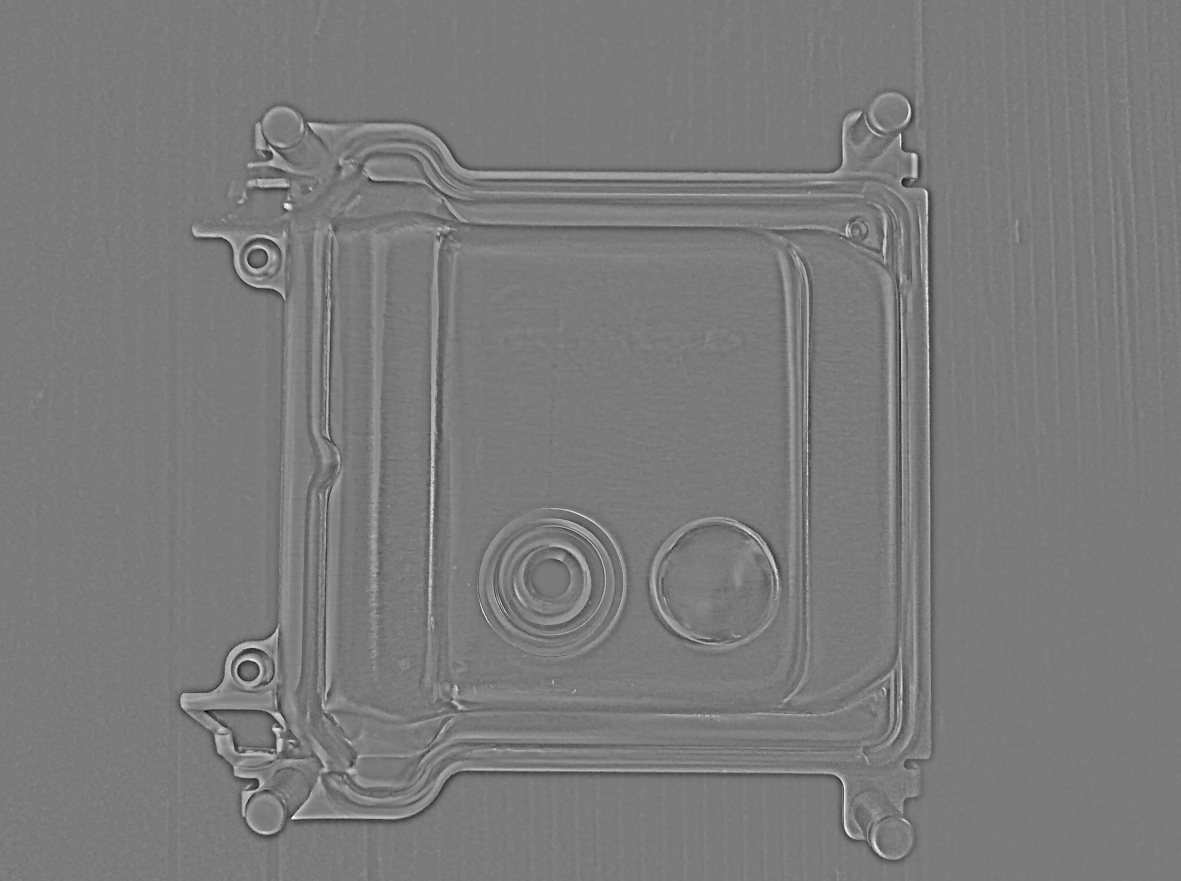

In [18]:
showLCN('test2.jpg',3)

torch.DoubleTensor	


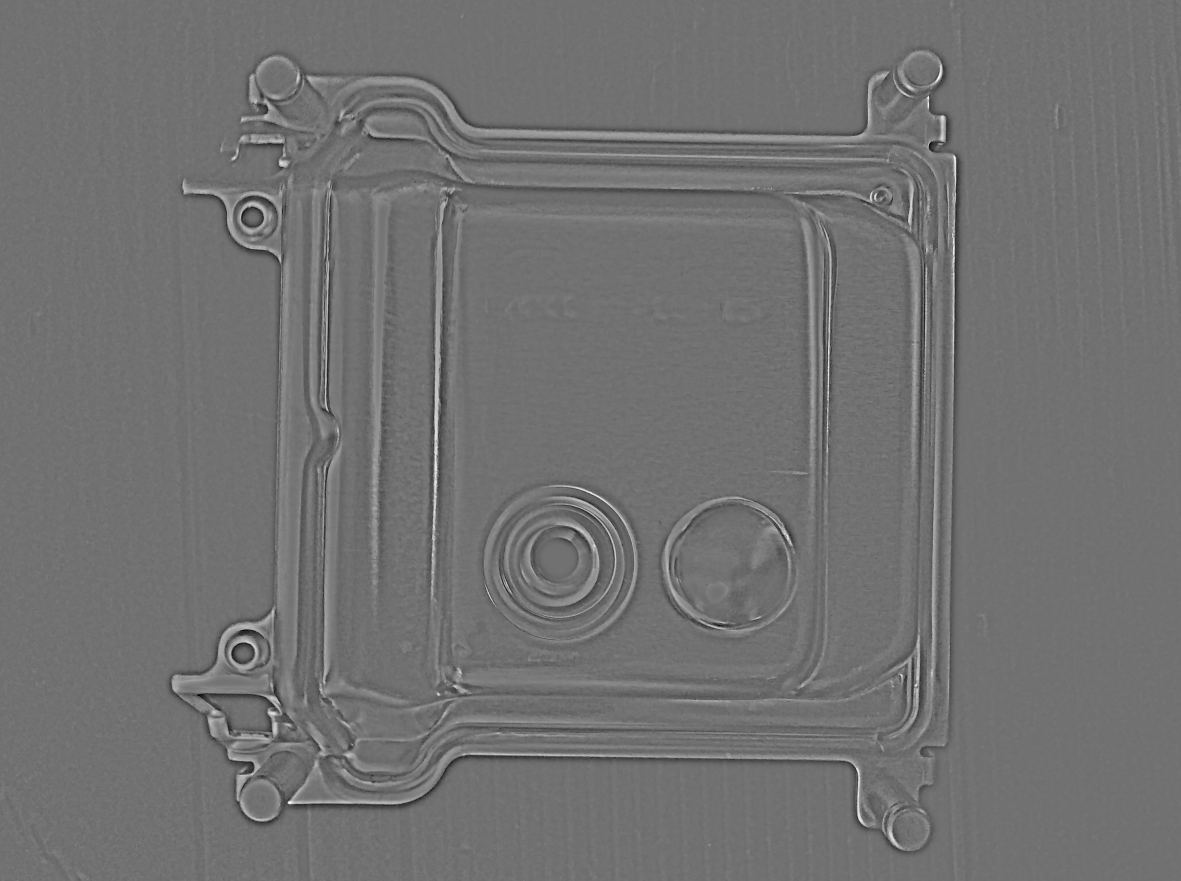

In [19]:
showLCN('test3.jpg',3)